<a href="https://colab.research.google.com/github/HarshitCodex/AI_Hackathon_2019/blob/master/Xray_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload ext_autoreload
%autoreload 2
%matplotlib inline

UsageError: Line magic function `%reload` not found.


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [0]:
Config.data_path()

PosixPath('/root/.fastai/data')

In [0]:
path= Config.data_path()/'Xray'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/Xray')

In [0]:
!kaggle datasets download -d nih-chest-xrays/sample

100% 2.09G/2.10G [00:43<00:00, 58.1MB/s]
100% 2.10G/2.10G [00:44<00:00, 51.2MB/s]


In [0]:
!unzip \*.zip

Archive:  sample.zip
  inflating: sample_labels.csv       
replace sample.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample.zip              


In [0]:
!unzip \*.zip

Archive:  sample.zip
  inflating: images/00000013_005.png  
  inflating: images/00000013_026.png  
  inflating: images/00000017_001.png  
  inflating: images/00000030_001.png  
  inflating: images/00000032_001.png  
  inflating: images/00000040_003.png  
  inflating: images/00000042_002.png  
  inflating: images/00000057_001.png  
  inflating: images/00000061_002.png  
  inflating: images/00000061_019.png  
  inflating: images/00000061_025.png  
  inflating: images/00000079_000.png  
  inflating: images/00000080_005.png  
  inflating: images/00000083_000.png  
  inflating: images/00000084_000.png  
  inflating: images/00000096_006.png  
  inflating: images/00000099_003.png  
  inflating: images/00000099_006.png  
  inflating: images/00000103_001.png  
  inflating: images/00000116_013.png  
  inflating: images/00000116_019.png  
  inflating: images/00000116_032.png  
  inflating: images/00000116_040.png  
  inflating: images/00000118_011.png  
  inflating: images/00000121_004.png  
  in

In [0]:
df=pd.read_csv('/content/sample_labels.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [0]:
df['Age Type']=df['Patient Age'].apply(lambda x: x[-1:])
df['Age Type'].unique()  # => Y, M and D
#we mainly have ages expressed in Years, but also a few expressed in Months or in Days
print(df[df['Age Type']=='Y']['Patient ID'].count())
print(df[df['Age Type']=='M']['Patient ID'].count())  
print(df[df['Age Type']=='D']['Patient ID'].count())

5604
1
1


In [0]:
df['Patient Age'].sort_values(ascending=False).head(20)

4242    411Y
3745    094Y
1807    089Y
3573    089Y
3092    089Y
5403    088Y
47      087Y
4998    087Y
2140    086Y
1206    085Y
681     085Y
2356    085Y
1737    085Y
5364    085Y
189     085Y
600     084Y
35      084Y
1270    084Y
590     083Y
2428    083Y
Name: Patient Age, dtype: object

In [0]:
labels=df

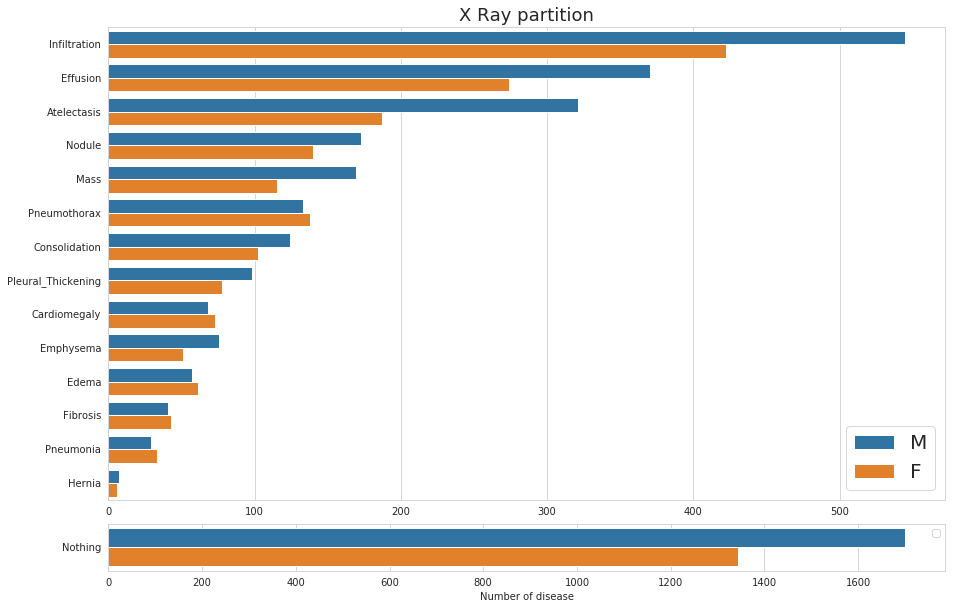

In [0]:
labels = labels[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]
#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    labels[pathology] = labels['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
#remove Y after age
labels['Age']=labels['Patient Age'].apply(lambda x: x[:-1]).astype(int)

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition',fontsize=18);

labels['Nothing']=labels['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of disease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

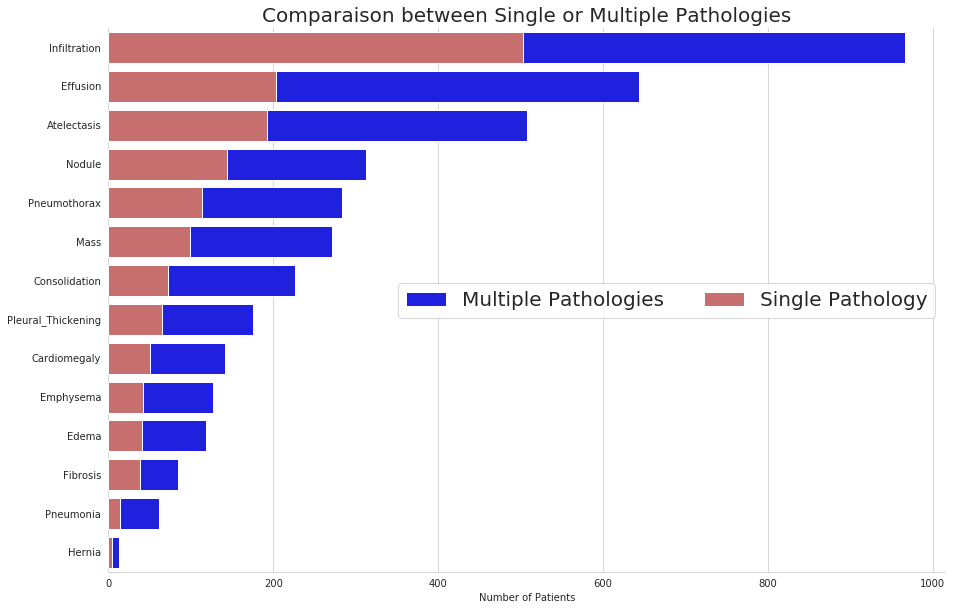

In [0]:
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

f, ax = plt.subplots(sharex=True,figsize=(15, 10))
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="r",label="Single Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of Patients")
ax.set_title("Comparaison between Single or Multiple Pathologies",fontsize=20)      
sns.despine(left=True)

In [0]:
 df.describe()

,Follow-up #,Patient ID,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
count,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000
mean,8.616661,14330.617017,2644.795755,2491.087406,0.155467,0.155467
std,15.565815,8411.477789,347.188754,399.119063,0.016201,0.016201
min,0.000000,13.000000,1362.000000,966.000000,0.115000,0.115000
25%,0.000000,7289.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,2542.000000,2544.000000,0.143000,0.143000
75%,10.000000,20655.500000,2992.000000,2991.000000,0.168000,0.168000
max,177.000000,30797.000000,3266.000000,3056.000000,0.198800,0.198800


In [0]:
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

In [0]:
tfms = get_transforms(flip_vert=False, max_lighting=0.15, max_zoom=1.05, max_warp=0.1)

In [0]:
path='/content'

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path,'sample_labels.csv', folder='images')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim='|'))



In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

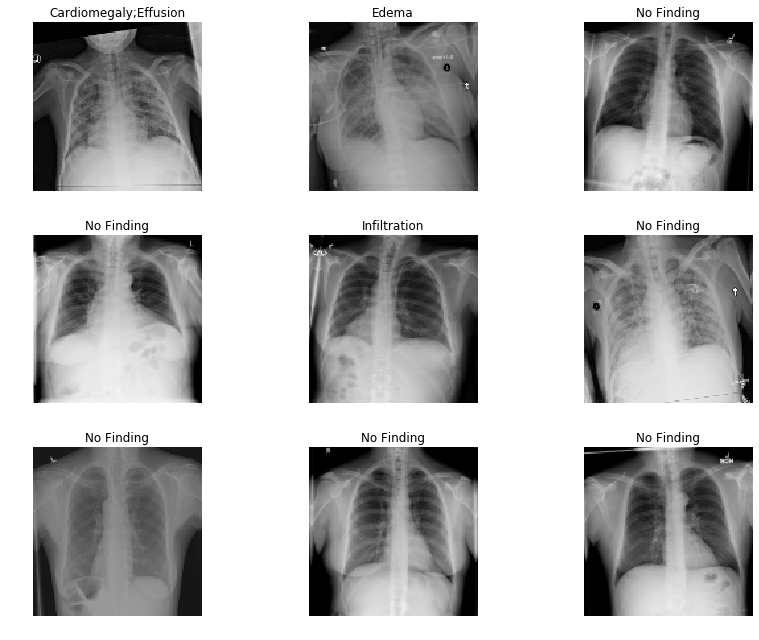

In [0]:
data.show_batch(rows=3,figsize=(12,9))

In [0]:
data

ImageDataBunch;

Train: LabelList (4485 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Emphysema;Infiltration;Pleural_Thickening;Pneumothorax,Cardiomegaly;Emphysema,No Finding,Atelectasis,Cardiomegaly;Edema;Effusion
Path: /content;

Valid: LabelList (1121 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
No Finding,No Finding,Mass;Nodule,No Finding,Consolidation;Mass
Path: /content;

Test: None

In [0]:
arch=models.resnet50

In [0]:
acc_02=partial(accuracy_thresh,thresh=0.2)
f_score=partial(fbeta,thresh=0.2)
learn=cnn_learner(data,arch,metrics=[acc_02,f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 99767646.84it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


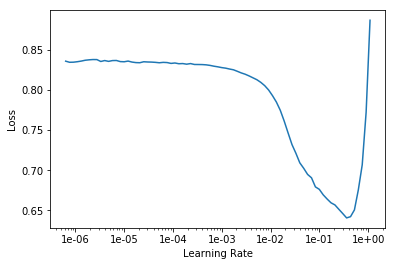

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.456964,0.223971,0.898959,0.569010,02:01
1,0.261193,0.207983,0.891288,0.577603,01:59
2,0.216168,0.203501,0.899911,0.579073,01:59
3,0.202260,0.200237,0.902825,0.589898,01:59
4,0.194574,0.198924,0.904490,0.592986,01:59


In [0]:
path='/content/drive/My Drive/Xray'

In [0]:
??learn.save

In [0]:
learn.save('stage-1-rn50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


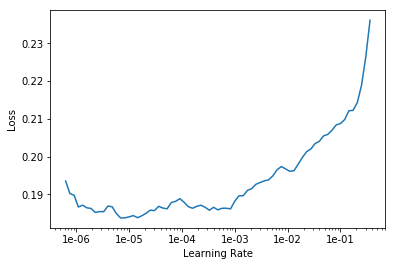

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,slice(1e-6,(1e-5)/2))

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('resnet50-lr')

In [0]:
learn.load('stage-1-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (4485 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Emphysema;Infiltration;Pleural_Thickening;Pneumothorax,Cardiomegaly;Emphysema,No Finding,Atelectasis,Cardiomegaly;Edema;Effusion
Path: /content;

Valid: LabelList (1121 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
No Finding,No Finding,Mass;Nodule,No Finding,Consolidation;Mass
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_s